In [1]:
import wandb
import random
# start a new wandb run to track this script


raw_data_dir = "DukePred_Transfer_Result/S"
state_dict_1st_UNet = "../data/synthetic/checkpoint_epoch58.pth"
state_dict_2nd_UNet = "../data/synthetic/checkpoint_epoch112.pth"

SS_NUM = 200
USE_WANDB = False
SHOW = True
if USE_WANDB:
    wandb.init(
        # set the wandb project where this run will be logged
        project="Test_Result",     
        # track hyperparameters and run metadata
        config={
            "Version": "Michael's",
            "state_dict_1st_UNet" :state_dict_1st_UNet,
            "state_dict_2nd_UNet" : state_dict_2nd_UNet,
            "SS_NUM": SS_NUM
        }
    )


    

In [2]:

"""
This is code for plotting the coverage maps as predicted by the isotropic and directional U-Nets.
"""

import logging
import os
import itertools

import math

import sys


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import numpy as np

from scipy import ndimage, datasets
from scipy.constants import speed_of_light

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchvision import transforms


from unet.unet_model_rt import UNet
from utils.utils import plot_img_and_mask

from CBRSUtils import CBRSUtils as cu

import random

from pathlib import Path



import pandas as pd
b_map_path_dict = {'C': "../data/test/0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
                  'D': "../data/test/0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
                  'A': "../data/test/0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
                  'B': "../data/test/0_c8681783-aa00-46e7-92b2-ca15c5beca67.npy",
                  'E': "../data/test/0_78d03890-be26-47f8-8b81-8485f0d19a83.npy",
                  'F': "../data/test/0_78d03890-be26-47f8-8b81-8485f0d19a83.npy"}

lat_lon_center_dict = {'C': (35.999186254897836, -78.9397858960648),
                            'D': (35.999186254897836, -78.9397858960648),
                            'A': (35.999186254897836, -78.9397858960648),
                            'B': (35.999186254897836, -78.9397858960648),
                            'E':  (36.00307128210248, -78.93706070613855),
                            'F':  (36.00307128210248, -78.93706070613855)}

lat_lon_top_left_dict = {'C': (36.001483241320656, -78.94273733701348),
                             'D': (36.001483241320656, -78.94273733701348),
                             'A': (36.001483241320656, -78.94273733701348),
                             'B': (36.001483241320656, -78.94273733701348),
                             'E': (36.005429554748495, -78.93998431793196), 
                             'F': (36.005429554748495, -78.93998431793196)}  # lat, lon pairs for top left corner



device_sql_dic = ["Samsung", "pixel", "rpi"]


pci_azimuth_dict = {
     'F': 216,
     'E': 216,
     'D': 30,
     'C': 30,
     'B': 212,
     'A': 212

}

measurement_data = pd.read_csv("../data/measurement/masked_cleaned_view.csv")



Measurement_Device:Samsung, PCI:A, SS_NUM: 200, PCI: A
    mPci   latitude  longitude   device  rsrp
203    A  35.998821 -78.940651  Samsung   -80
571    A  35.999005 -78.940536  Samsung   -88
573    A  35.998797 -78.940672  Samsung   -81
598    A  35.999466 -78.940202  Samsung  -110
600    A  35.998288 -78.939732  Samsung   -88
623    A  35.998594 -78.940340  Samsung   -78
631    A  35.998878 -78.939250  Samsung  -102
654    A  35.998372 -78.939877  Samsung   -81
690    A  35.998414 -78.939588  Samsung   -83
712    A  35.999556 -78.940316  Samsung  -109
tx_height 24
# of points for sparse input:  200
# of points for ground_truth:  1850
1850
number of points where there's a building 7


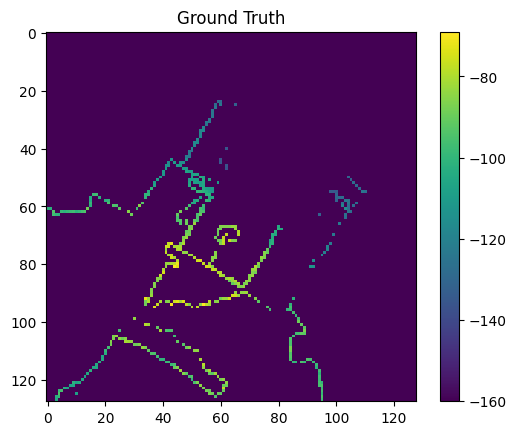

In [3]:
device_name = "Samsung"
which_PCI = "A"


print('Measurement_Device:%s, PCI:%s, SS_NUM: %d, PCI: %s' % (device_name, which_PCI, SS_NUM, which_PCI))
save_iso_output_name = 'PCI=%s_iso_UNet_out' % (which_PCI)

def log(log_dict, commit_flag=False):
    if USE_WANDB:
        wandb.log(log_dict,commit=commit_flag) 


df_SigCapDetails = measurement_data[(measurement_data['mPci'] == which_PCI) & (measurement_data['device'] == device_name)]
print(df_SigCapDetails[0:10])

log({"Total Measurement Points": len(df_SigCapDetails["latitude"])})
# 3.Load data
# first, get idx_uuid.npy (building map name)
name = b_map_path_dict[which_PCI].split("/")[-1]

# load building map and downsample
building_height_ori = np.load(b_map_path_dict[which_PCI])
building_height_ori = building_height_ori[0:512, 0:512]
building_height_arr = building_height_ori[::4, ::4]


name_splited = name.split("_")
file_name_id_part = name_splited[0]  # idxuuid
tx_x = 256
tx_y = 256
tx_position = [tx_x // 4, tx_y // 4]
tx_height = 24
# tx_height = np.max(building_height_arr)
if SHOW:
    print('tx_height', int(tx_height))
log({"tx_height": int(tx_height)})

distance = np.arange(0, 1450, 1)

# lookup table for path_loss_res, resolution=1 meter
path_loss_res =  cu.pathloss_38901(distance,3.64, h_bs=int(tx_height), h_ut=2)

# generate list of tuples of (numpy_row, numpy_col, rsrp) by converting lat,lon into 
# local coordinates. 'list of tuples' is represented by np.array
measurement = np.empty([len(df_SigCapDetails["latitude"]), 3])
measurement[:, 0] = df_SigCapDetails["latitude"]
measurement[:, 1] = df_SigCapDetails["longitude"]
measurement[:, 2] = df_SigCapDetails["rsrp"]

for idx, point in enumerate(measurement):
    row, col = cu.gps2local(measurement[idx,0], measurement[idx,1], 
                            top_left_latitude=lat_lon_top_left_dict[which_PCI][0],
                            top_left_longitude=lat_lon_top_left_dict[which_PCI][1])
    measurement[idx, 0] = row
    measurement[idx, 1] = col

# get sparse_ss
ground_truth_list, sparse_ss_arr = np.split(np.random.default_rng(seed=42).permutation(measurement), [len(measurement)-200])
ground_truth_list = measurement

sparse_ss_arr[:, 0] = sparse_ss_arr[:, 0]/4.0
sparse_ss_arr[:, 1] = sparse_ss_arr[:, 1]/4.0

increment_permutations = np.array(list(itertools.permutations([-1, 0, 1]))).reshape(-1, 1)

def col_row_for_no_building(row_, col_, bh_arr=building_height_arr, 
                            increment=increment_permutations):
    """
    :param row_: index that has height != 0
    :param col_: index that has height != 0
    :param bh_arr: building height array
    :param increment: tuples for incrementing [row,col]
    """
    for iii in range(3):
        for jjj in range(3):
            try: 
                height_ = bh_arr[row_+increment[2*iii][jjj], col_+increment[2*iii+1][jjj]]
            except IndexError:
                continue
            if height_ == 0:
                return row_+increment[2*iii][jjj], col_+increment[2*iii+1][jjj]
    # cannot find no building area in 3x3 region
    return None, None
if SHOW:
    print("# of points for sparse input: ", len(sparse_ss_arr))
    print("# of points for ground_truth: ", len(ground_truth_list))


ground_truth_tmp =  np.empty((128, 128), dtype=object)
count_num_no_building = 0

print(len(ground_truth_list))
for point in ground_truth_list:
    row = int(point[0]/4)
    col = int(point[1]/4)
    if row >=128 or col >= 128 or row < 0 or col < 0:
        #print("{}:{}".format(row,col))
        continue
    #valid_num_mea_dic[device_name][which_PCI] = valid_num_mea_dic[device_name][which_PCI] +1
    if building_height_arr[row,col] != 0:
        row, col = col_row_for_no_building(row, col)  # attempts to update row, col 
        if row is None or col is None:  # didn't find good row, col
            count_num_no_building += 1
            continue
    if ground_truth_tmp[row, col] is None:
        ground_truth_tmp[row, col] = np.array(point[2])
    else:
        ground_truth_tmp[row][col] = np.append(ground_truth_tmp[row][col], point[2])
        
if SHOW:
    print("number of points where there's a building", count_num_no_building)
log({"number of points where there's a building": count_num_no_building})

ground_truth_arr = np.empty((128, 128))
for row in range(128):
    for col in range(128):
        if ground_truth_tmp[row, col] is None:
            ground_truth_arr[row][col] = -160
            
        else:
            ground_truth_arr[row][col] = ground_truth_tmp[row,col].mean()
            ground_truth_arr[row][col] = np.median(ground_truth_tmp[row,col])
            ground_truth_arr[row][col] = 10 * np.log10( ( 10 ** ( ground_truth_tmp[row,col]/ 10)  ).mean() )


plt.imshow(ground_truth_arr, interpolation='none')
plt.title("Ground Truth")
plt.colorbar()
plt.show()

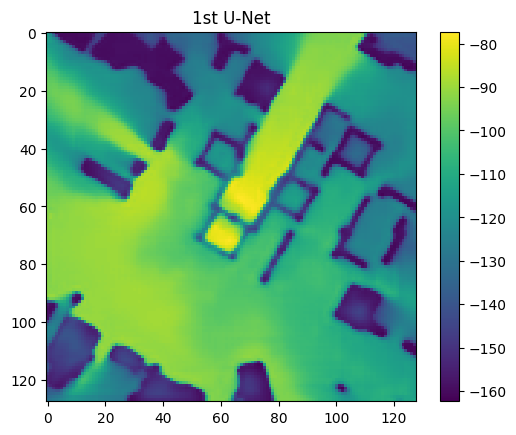

In [4]:
'''
Random pick x points and then compute the mean of it
'''      
ss_map = np.full((128, 128), -160)
tmp_ss_list = []
count = 0
while count < 100:
            
    xx = random.randint(0, 127)
    yy = random.randint(0, 127)
    if ground_truth_arr[xx][yy] != -160 and ss_map[xx][yy] == -160:
        count+=1
        ss_map[xx][yy] = ground_truth_arr[xx][yy]
        tmp_ss_list.append(ground_truth_arr[xx][yy])
GT_mean =  sum(tmp_ss_list) / len(tmp_ss_list)
# '''
# Generate the fitted Sionna Result
# '''  
# sionna_cm = 10 * np.log10(np.flip(np.load(sionna_cm_path_dict[which_PCI]),0))
# sionna_cm = np.where(building_height_arr!=0, -160, sionna_cm)
# sionna_cm = np.where(np.isinf(sionna_cm), -160, sionna_cm)




# Construct the TX position channel
tx_position_channel = np.full((128, 128), 0, dtype=int)
tx_position_channel[tx_position[1]][tx_position[0]] = tx_height


path_loss_heat_map = np.full((128, 128), 0, dtype=float)



for row in range(path_loss_heat_map.shape[0]):
    for col in range(path_loss_heat_map.shape[1]):
        # Compute the distance between pixel and tx
        dist = math.sqrt((tx_position[1]*4 - row*4)**2 + (tx_position[0]*4 - col*4)**2)
        path_loss_heat_map[row][col] =  -1 * path_loss_res[int(dist)]


net_iso = UNet(n_channels=2, n_classes=1, bilinear=False, pathloss=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net_iso.to(device=device)


# 2.Load state dict
#state_dict = torch.load(state_dict_1st_UNet, map_location=device)
state_dict = torch.load(state_dict_1st_UNet, map_location=device)

net_iso.load_state_dict(state_dict)


# Since right now GT.size is 100*100 and other two size is 1000 * 1000, just check the input.
# assert building_height_arr.shape == terrain_height_aimport loggin
combined_input = np.zeros((4, 128, 128), dtype=float)

# Combine all the channels together
combined_input[0,:, :] = np.copy(building_height_arr)

#
combined_input[1,:, :] = tx_position_channel
combined_input[2,:, :] = path_loss_heat_map


batch = {
            'combined_input': torch.as_tensor(combined_input.copy()).float().contiguous(),
            'ground_truth': torch.as_tensor(ground_truth_arr.copy()).long().contiguous(),
            'file_name': name,
            'sparse_ss': torch.as_tensor(sparse_ss_arr.copy()).float().contiguous()
        }


# Eval
images, ground_truth = batch['combined_input'], batch['ground_truth']
sparse_ss = batch['sparse_ss']

# Since we directly load the data by manual, add batch dimension to the front of data
images = images[None,:, :, :]
sparse_ss = sparse_ss[None,:, :]


net_iso.eval()

images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
ground_truth = ground_truth.to(device=device, dtype=torch.long)
sparse_ss = sparse_ss.to(device=device, dtype=torch.float32)

with torch.no_grad():
    output = net_iso(images, sparse_ss).squeeze().cpu()

output_iso_UNet = output.squeeze().cpu().numpy()


plt.imshow(output_iso_UNet, interpolation='none')
plt.title("1st U-Net")
plt.colorbar()
plt.show()

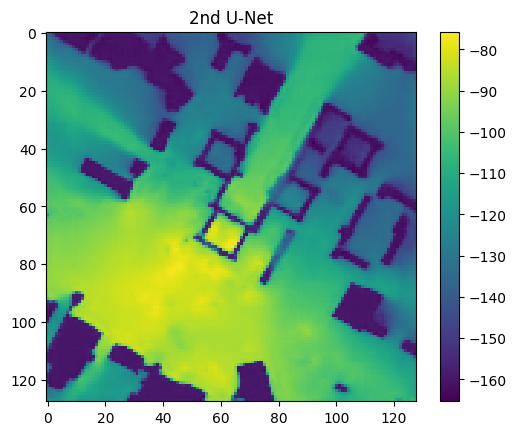

In [5]:
# UNet for tr38901

# 1.Create the Model
net = UNet(n_channels=3, n_classes=1, bilinear=False, pathloss=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device=device)


# 2.Load state dict
#state_dict = torch.load("../Pytorch-UNet-master/checkpoints_transfer/checkpoint_epoch21.pth", map_location=device)
state_dict = torch.load(state_dict_2nd_UNet, map_location=device)

net.load_state_dict(state_dict)




# Since right now GT.size is 100*100 and other two size is 1000 * 1000, just check the input.
# assert building_height_arr.shape == terrain_height_aimport loggin
combined_input = np.zeros((3, 128, 128), dtype=float)

# Combine all the channels together
combined_input[0,:, :] = building_height_arr
ss_map = np.full((128, 128), -160)

res = []
ss_map = np.full((128, 128), -160)
count = 0
while count < SS_NUM:
    
    xx = random.randint(0, 127)
    yy = random.randint(0, 127)
    if ground_truth_arr[xx][yy] != -160 and ss_map[xx][yy] == -160:
        count+=1
        ss_map[xx][yy] = ground_truth_arr[xx][yy]

combined_input[1,:, :] = ss_map

combined_input[2,:, :] = output_iso_UNet
#combined_input[2,:, :] = output_iso_UNet

batch = {
            'combined_input': torch.as_tensor(combined_input.copy()).float().contiguous(),
            'ground_truth': torch.as_tensor(ground_truth_arr.copy()).long().contiguous(),
            'file_name': name,
            'sparse_ss': torch.as_tensor(sparse_ss_arr.copy()).float().contiguous()
        }


# 4. Eval
images, ground_truth = batch['combined_input'], batch['ground_truth']
sparse_ss = batch['sparse_ss']

# Since we directly load the data by manual, add batch dimension to the front of data
images = images[None,:, :, :]
sparse_ss = sparse_ss[None,:, :]


net.eval()

images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
ground_truth = ground_truth.to(device=device, dtype=torch.long)
sparse_ss = sparse_ss.to(device=device, dtype=torch.float32)

with torch.no_grad():
    output = net(images, sparse_ss).cpu()

output = output.squeeze().cpu().numpy()

plt.imshow(output, interpolation='none')
plt.title("2nd U-Net")
plt.colorbar()
plt.show()